### 3.6 손글씨 숫자 인식

이번 장에서는 추론 과정만 구현해본다.
추론은 신경망의 순전파 (foward propagation) 이라고도 한다.
신경망 역시 기계학습과 마찬가지로 훈련 데이터를 사용해 가중치 매개변수를 학습하고,
추론 단계에서는 앞서 학습한 매개 변수를 사용하여 입력 데이터를 분류한다.

#### 3.6.1 MNIST 데이터셋

MNIST는 손글씨 숫자 이미지 집합이다.
60,000장의 훈련 데이터, 10,000장의 시험 데이터로 구성된다.

이미지 데이터는 28 X 28 크기의 회색조 이미지(1채널) 이며, 각 픽셀은 0~255까지의 값을 취한다.
각 이미지에는 그 이미지가 실제 의미하는 숫자가 레이블로 붙어 있다.

MNIST 데이터셋을 받아 이미지를 넘파이 배열로 변환해주는 minist.py를 임포트하여 데이터를 가져와보자.

In [2]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist

# 처음 한 번은 몇 분 정도 걸린다고 한다.
(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten = True, normalize = False)

# 각 데이터의 형상 출력
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
(60000, 784)
(60000,)
(10000, 784)
(10000,)


load_mnist 함수는 읽은 MNIST 데이터를 "(훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)" 형식으로 반환한다.
인수로는 normalize, flatten, one_hot_label 세 가지를 설정할 수 있다. 모두 bool 값이다.

1) normalize
입력 이미지의 값을 0.0 ~ 1.0 사이의 값으로 정규화할지를 정한다.
False로 설정하면 입력 이미지의 픽셀은 원래 값 그대로 0 ~ 255 사이의 값을 유지한다.

2) flatten
입력 이미지를 1차원 배열로 만들지를 정한다.
Flase로 설정하면 입력 이미지응 1 X 28 X 28의 3차원 배열로, 
True로 설정하면 784개의 원소로 이뤄진 1차원 배열로 저장한다.

3) one_hot_label
레이블을 원-핫 인코딩(one-hot-encoding) 형태로 저장할지를 정한다.
원-핫 인코딩이란 정답을 뜻하는 원소만 1이고 나머지는 모두 0인 배열이다.
False로 설정하면 '7'과 같은 숫자 형태의 레이블을 저장한다.

이제 이미지를 화면으로 불러보자
PIL 모듈을 사용한다.

5
(784,)
None


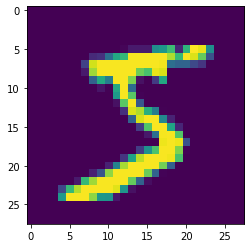

In [12]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from PIL import Image
from matplotlib.pyplot import imshow

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img)) # 이미지로 변환시켜 준다.
    # pil_img.show()
    imshow(pil_img)
    
(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten = True, normalize = False)

img = x_train[0]
label = t_train[0]
print(label)
print(img.shape) # flatten을 True로 해서 1차원 배열로 나옴 
img = img.reshape(28, 28) # 이미지를 출력하려면 원래 형상으로 변형시켜야 한다.

print(img_show(img))

#### 3.6.2 신경망의 추론 처리

이제 이 데이터셋을 가지고 추론 처리하는 신경망을 구현한다.
신경망의 입력층 뉴런은 784개, 출력층 뉴런을 10개로 구성한다.
은닉층은 총2개로, 첫번째는 50개의 뉴런을, 두번째는 100개의 뉴런을 배치한다.
해당 값들은 임의로 정한 것.

In [37]:
import pickle

def sigmoid(x):
    return 1 / (1+np.exp(-x))

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

def get_data():
    (x_train, t_train), (x_test, t_test) = \
        load_mnist(normalize = True, flatten = True, one_hot_label = False)
    return x_test, t_test

def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    # print(W1.shape, W2.shape, W3.shape)
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)
    
    return y

In [38]:
x, t = get_data()
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    if p == t[i]: accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


먼저 데이터셋을 얻고 네트워크를 생성한다.

그리고는 반복문을 돌면서 x에 저장된 이미지 데이터를 1장씩 꺼내 predict() 함수로 분류한다.
predict() 함수는 각 레이블에 대한 확률을 넘파이 배열로 반환한다.
[0.1, 0.3, 0.2, ..., 0.04] 와 같은 배열로 반환되는데 이는

이미지가 숫자 0일 확률이 0.1, 1일 확률이 0.3 ... 식으로 해석된다.
그런 다음 argmax() 함수로 이 배열에서 값이 가장 큰 원소의 인덱스를 구한다.
그리고 정답 레이블과 비교하여 맟힌 숫자를 센 뒤, 전체 이미지 숫자로 나눠 정확도를 구한다.

데이터를 불러올때 normalize를 활성화 시키는데, 이는 이미지 각 픽셀의 0 ~ 255의 값을 0.0 ~ 1.0 범위로 변환시킨다.
이처럼 데이터를 특정 범위로 변환하는 처리를 정규화 (normalization) 이라고 하며,
신경망의 입력 데이터에 특정 변환을 가하는 것을 전처리 (pre-processing) 이라 한다.

해당 신경망에서는 전처리로 정규화를 진행한 것이다.

(왜 정규화를 하는가?
정규화를 하지 않으면 값이 0 ~ 255이기에 작은값은 무시되고 큰 값만 더 강조되는 현상이 발생하기 때문.
신경망이 제대로 학습을 하지 못하는 현상 발생함.)

실제 현업에서는 데이터 전체의 분포를 고려해 전처리를 하는 경우가 많다.
데이터 전체 평균과 표준편차를 이용해 데이터들이 0을 중심으로 분포하도록 이동하거나
데이터의 확산 범위를 제한하는 정규화를 수행한다.
그 외에도 전체 데이터를 균일하게 분포시키는 데이터 백색화 (whitening)도 존재한다.

#### 3.6.3 배치 처리

입력 데이터와 가중치 매개변수의 '형상'에 주의해서 보자

In [39]:
x, _ = get_data()
network = init_network()
W1, W2, W3 = network['W1'], network['W2'], network['W3']

print(x.shape, W1.shape, W2.shape, W3.shape)

(10000, 784) (784, 50) (50, 100) (100, 10)


한 장의 이미지를 처리할 때는 다음과 같은 흐름으로 진행된다.  

입력 X: (784,) (784, 50) (50, 100) (100 10) -> (10)  

그럼 이미지 100장을 한번에 묶어서 predict()에 넘기면 어떻게 될까?  

(100, 784) (784, 50) (50, 100), (100, 10) -> (10, 100)  
출력 데이터의 형상은 10, 100으로 100장 분량의 입력 데이터의 결과가 한 번에 출력됨을 의미한다.  
x[0]과 y[0]에는 0번째 이미지와 그 추론 결과가 저장되는 방식이다.  

이처럼 하나로 묶은 입력 데이터를 배치 (batch)라 한다. 배치가 곧 묶음의란 의미이다.  

BUT WHY BATCH?  
이미지 1장당 처리 시간을 대폭 줄여주는 역할을 한다.  
1) 수치 계산 라이브러리들은 대부분 큰 배열을 효율적으로 처리하도록 고도의 최적화가 되어있다.  
2) 커다란 신경망에서는 데이터 전송 자체가 병목으로 작용할때가 있는데, 배치 처리를 함으로서 버스에 주는 부하를 줄인다.  

느린 I/O의 데이터를 읽는 횟수를 줄여주는것.  
배치 처리를 수행함으로 큰 배열로 이뤄진 계산을 하게 되는데, 컴퓨터는 큰 배열이 분할된 작은 배열 여러번 계산하는 것보다 빠르다.  

In [44]:
x, t = get_data()
network = init_network()

batch_size = 100 # 배치 크기
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i : i + batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis = 1) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    
    print(y_batch)
    print()
    print(p)
    accuracy_cnt += np.sum(p == t[i : i + batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

[[3.29137561e-06 1.02745240e-07 2.78982534e-05 4.90758612e-05
  4.57291378e-08 1.75426385e-06 6.34363784e-10 3.88771258e-02
  3.65525693e-07 3.19072387e-05]
 [2.38913308e-05 5.45662351e-06 4.66457708e-03 7.06867577e-05
  2.81526913e-09 3.29794420e-05 1.36013812e-04 6.27792085e-09
  6.35489596e-06 2.36451109e-10]
 [4.35423003e-10 4.15725028e-03 1.80313382e-05 7.49591300e-06
  5.53756252e-07 3.19225296e-06 1.97111399e-06 9.54207553e-06
  5.20351978e-06 3.64514079e-07]
 [1.26391789e-02 1.04401165e-09 2.02235315e-05 2.41281009e-06
  5.49404149e-08 4.28640560e-05 5.16990440e-06 2.94927577e-06
  6.14853889e-07 5.34488834e-07]
 [3.63747318e-07 1.15563381e-08 5.08723360e-06 5.85677178e-08
  1.68065762e-03 8.47780086e-07 3.58964303e-06 9.65850541e-06
  2.52931250e-06 5.74644218e-05]
 [1.77337728e-10 5.78273740e-03 1.01278010e-05 1.30993130e-05
  4.94069695e-07 1.74704803e-06 2.03225767e-07 2.79188280e-05
  1.11904683e-05 2.48993751e-06]
 [1.27649633e-08 1.51145613e-07 6.71478304e-08 4.82207327e

[[9.29833135e-08 3.42361545e-06 3.04720124e-05 4.84615668e-07
  4.12083464e-05 6.36749019e-06 4.14648419e-03 2.84954034e-08
  3.87099772e-06 1.81914501e-07]
 [4.91344908e-05 1.13787797e-08 3.13467240e-07 5.23192330e-06
  7.92671756e-07 4.61169984e-04 1.93801526e-08 2.48692140e-06
  9.71396366e-05 9.95773735e-05]
 [3.99350114e-07 1.72334990e-06 1.82288604e-05 1.04245726e-06
  2.56454969e-05 6.58767794e-06 3.19811329e-03 2.03838169e-07
  4.32959126e-07 1.58830346e-07]
 [2.67802670e-06 5.30927082e-07 3.85288985e-07 1.38119813e-05
  3.36364610e-06 1.97486696e-03 1.43149982e-05 1.57715121e-08
  3.78148688e-05 3.56541420e-07]
 [5.21145580e-08 7.05475941e-06 3.21159177e-06 4.90960811e-05
  1.49591713e-07 2.56744988e-05 8.25588664e-09 8.21949470e-06
  3.45962908e-04 3.65607484e-05]
 [4.15020259e-06 7.68187025e-09 1.19489650e-05 3.03103853e-08
  4.55935835e-04 4.82163887e-06 1.21036246e-05 2.69398265e-06
  7.09474216e-06 1.19451252e-05]
 [6.86896442e-07 5.58824297e-07 1.76993181e-05 6.20468711e

  3.22710343e-06 1.48842609e-08]]

[6 0 2 0 0 0 8 8 3 1 5 3 3 8 5 1 8 8 6 4 9 4 6 2 3 3 5 6 4 8 0 9 2 3 2 6 9
 5 1 2 9 4 9 1 2 8 2 0 3 0 4 1 1 5 7 0 9 9 1 9 5 9 3 5 0 4 1 0 8 4 0 8 9 8
 9 4 2 5 7 9 8 9 8 0 9 9 6 8 9 9 5 9 8 6 1 0 3 3 5 2]
[[6.12078097e-11 7.39716180e-03 8.48860327e-06 4.43748613e-05
  7.03014450e-07 9.12229552e-07 1.10418164e-07 5.35553008e-05
  1.32847608e-05 1.03774182e-05]
 [1.27464264e-05 3.66118627e-07 5.84238878e-05 7.39441759e-07
  2.48641527e-06 3.32877680e-05 3.46095441e-03 1.41126870e-08
  3.92882203e-06 8.82438034e-09]
 [6.17630849e-06 8.88139425e-07 1.90919091e-05 5.50584460e-04
  8.85229579e-09 1.00030775e-05 5.12636866e-08 5.03634801e-05
  1.28331055e-06 3.96975020e-06]
 [3.86822149e-02 7.39058481e-10 1.99098358e-05 2.70695637e-06
  7.72936559e-08 9.22352265e-05 1.11692370e-05 6.31259581e-07
  9.73010060e-07 3.56575640e-07]
 [9.34440223e-08 6.14271703e-05 7.49683334e-03 1.22132464e-04
  7.49459872e-09 2.09079462e-06 6.32661454e-07 1.37193649e-06
  5.37401

[[2.44821586e-05 3.31206138e-08 1.02136610e-08 2.51391721e-05
  5.83042628e-08 5.23250783e-03 2.54214978e-08 3.75679065e-07
  1.55733346e-06 1.46550826e-06]
 [1.55549901e-06 2.65304863e-07 2.05490801e-06 3.53741189e-06
  2.82278506e-07 3.97707699e-05 2.01969073e-04 1.54182045e-09
  3.94396147e-06 2.40096707e-08]
 [7.96439323e-08 2.60342944e-07 7.74748332e-06 1.17513182e-05
  2.62008868e-08 4.79869755e-07 1.43795378e-10 2.49614939e-02
  3.25208390e-07 3.28935494e-05]
 [6.45275477e-09 4.37911723e-07 5.22885557e-07 5.25634641e-06
  2.54699353e-06 5.07074856e-06 2.48973695e-08 9.07417856e-08
  4.01423720e-04 1.54127083e-05]
 [1.43117482e-08 6.09758501e-08 1.66919989e-08 3.11817257e-06
  1.24808057e-05 5.56503437e-06 4.94329155e-09 6.74390367e-06
  8.55774124e-06 2.73640989e-03]
 [2.15849914e-02 1.82102652e-10 5.53428208e-07 5.15754891e-07
  1.47856669e-08 5.15326741e-04 1.70290036e-07 9.36416598e-07
  7.93399749e-07 5.55303416e-07]
 [5.13045162e-10 4.23829304e-04 2.36740416e-05 8.38469589e

[[1.30496019e-07 1.06122980e-05 7.61642493e-03 2.55312480e-05
  3.91487509e-09 3.46766285e-07 2.18990763e-07 2.56817862e-06
  2.52589361e-05 5.90607527e-08]
 [1.62727531e-09 2.21465683e-07 1.10993028e-08 1.59956002e-07
  2.30840147e-02 8.26892574e-06 2.91888568e-06 2.43218210e-06
  2.59327498e-06 3.14431265e-04]
 [6.72292777e-10 1.90275819e-06 6.96698592e-08 5.37444862e-07
  1.71998353e-03 6.09645485e-06 2.42849683e-06 6.07278253e-07
  1.57841932e-05 5.98450861e-05]
 [4.67997872e-08 3.64260291e-06 6.01661486e-06 5.92534523e-03
  2.26570496e-08 1.37311081e-05 1.43727108e-09 1.07859319e-06
  5.61610104e-05 4.10445818e-06]
 [6.48696314e-08 7.54337066e-07 1.02194499e-05 1.98989525e-03
  2.29592942e-07 2.98702821e-06 8.48102033e-09 2.55510969e-07
  4.70504638e-05 9.00872146e-06]
 [6.89871797e-07 1.78175824e-07 8.38280612e-05 1.65599623e-08
  6.17926926e-05 2.78587640e-06 1.31682632e-02 6.18254035e-08
  3.22916691e-07 2.55789292e-08]
 [3.39245187e-09 2.26806378e-06 1.37888776e-08 1.60089694e

[[1.99009662e-08 2.05545962e-08 1.09220608e-07 1.94445519e-07
  1.86494682e-02 2.14150623e-06 5.52398387e-06 2.16133208e-06
  6.23816788e-07 8.23081355e-05]
 [1.66259650e-02 4.73701800e-10 9.18356454e-06 9.38276457e-07
  7.83670373e-08 5.34437459e-05 5.53907648e-06 3.01891504e-07
  1.00680325e-06 2.53435758e-07]
 [1.64778680e-06 6.53702614e-07 4.85546025e-07 9.49775786e-05
  1.22831949e-08 1.02181977e-03 1.52420938e-08 3.96244246e-07
  1.88823149e-04 3.87749481e-07]
 [7.31312895e-08 5.05840063e-08 2.59854271e-08 7.09630513e-06
  1.29440477e-05 2.43050199e-05 1.89130240e-08 2.23598490e-05
  3.31737692e-06 2.17810948e-03]
 [3.81731070e-07 5.39067138e-08 3.68127893e-08 2.46530999e-05
  1.23870450e-06 8.09883422e-05 7.89976795e-09 8.70351778e-06
  7.28420810e-06 6.90078363e-04]
 [3.75931359e-06 7.66605268e-08 2.32177281e-05 8.11159964e-07
  9.53528030e-08 1.07156529e-05 2.46716922e-07 2.89916020e-08
  2.83202739e-03 1.82426072e-06]
 [1.28787614e-09 8.67565291e-07 1.57994844e-08 2.30655805e

[[1.06199525e-06 1.30812396e-06 1.82965692e-07 1.51742142e-06
  2.82446194e-06 1.54565834e-03 2.07346966e-06 3.62011690e-07
  1.58170824e-05 1.22511537e-07]
 [6.72767982e-02 6.52593368e-10 2.89275376e-05 7.09539654e-06
  1.38691361e-08 1.67433478e-04 4.34947788e-06 9.10884864e-07
  1.96743727e-07 6.73521470e-08]
 [2.43410681e-10 7.17571517e-03 4.06537729e-05 6.68557459e-06
  3.39143469e-07 1.08662209e-06 1.71216232e-06 2.18666059e-06
  1.61415410e-05 3.27828786e-07]
 [1.40110330e-07 3.48308640e-05 1.30462078e-02 2.83371501e-05
  3.48343008e-08 5.00890906e-07 2.01492749e-05 1.74959851e-08
  2.77990257e-05 4.68624028e-09]
 [1.17605191e-06 4.86694444e-06 3.14487334e-05 3.46236303e-02
  6.46969500e-09 1.25119303e-04 1.31012953e-07 1.23102168e-07
  3.69133613e-06 6.84117163e-09]
 [1.38954093e-07 1.75994401e-08 7.36936329e-07 4.02394811e-08
  8.35498888e-03 4.44084208e-06 1.53706114e-05 3.77902506e-06
  8.99487475e-07 1.23714744e-05]
 [8.63555726e-07 2.86537806e-06 2.34482150e-06 3.89418830e

range 함수는 (start, end)의 두 인자를 주면 start부터 end - 1까지 정수를 차례로 반환하는 반복자 (iterator)를 돌려준다.  
(start, end, step)처럼 세 인자를 주면 start부터 end - 1까지 step 간격으로 정수를 반환하는 반복자를 돌려준다.  

In [43]:
print(list(range(1, 10)))

print(list(range(1, 10, 2)))

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 3, 5, 7, 9]


range()에서는 함수가 반환하는 반복자를 바탕으로 x[i : i + batch_size]에서 입력 데이터를 묶는다.  
i부터 i+batch_size번째까지의 데이터를 묶는 다는 뜻  
x[0:100], [100:200], ...  

그리고 argmax에서는 최댓값의 인덱스를 가져오는데, axis = 1이라는 인수가 추가된다.  
이는 100 X 10의 배열중 1번째 차원을 구성하는 각 원소에서 (1번째 차원을 축으로) 최댓값의 인덱스를 찾도록 한 것이다.  
0번째는 데이터의 개수, 1번째는 각 데이터에 해당되는 확률값이 들어있으니. 
만약 axis를 0으로 두면 각 데이터의 인덱스마다 몇번째 데이터가 가장 값이 큰지를 출력해줄 것이다.

In [48]:
x = np.array([[0.1, 0.8, 0.1], [0.3, 0.1, 0.6], [0.2, 0.5, 0.3], [0.8, 0.1, 0.1]])
y = np.argmax(x, axis = 1)
print(y)

[1 2 1 0]


이제 배치 단위로 분류한 결과를 실제 답과 비교한다.  
넘파이 배열끼리 비교하여 True/False로 구성된 bool 배열을 만들고 True가 몇개인지 센다.  

In [49]:
y = np.array([1, 2, 1, 0])
t = np.array([1, 2, 0, 0])
print(y == t)
print(np.sum(y == t))

[ True  True False  True]
3
